In [1]:
import os
import numpy as np
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [25]:
def random_sample(Args, catalog):
    """Randomly picks entries from input catlog that are brighter than 25.3
    mag in the i band. The centers are randomly distributed within 1/5 of the
    stamp size.
    """
    number_of_objects = np.random.randint(2, Args.max_number)
    q, = np.where(catalog['i_ab'] <= 25.3)
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = btk.create_blend_generator.get_random_center_shift(Args, number_of_objects-1)
    blend_catalog['ra'][1:] += dx
    blend_catalog['dec'][1:] += dy
    return blend_catalog

In [36]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=4, batch_size=1)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catlog(catalog_name)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, sampling_function=random_sample)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

In [79]:
import tensorflow as tf

n_train_samples = 1024
n_val_samples = 128
batch_size = 32

def _draw_batch(arg):
    res = next(draw_blend_generator)
    return (res['blend_images'][0], res['isolated_images'][0,0])

plop = _draw_batch(None)
input_shape = plop[0].shape

def func_map(arg):
    x, y = tf.py_func(_draw_batch, [arg], [tf.float64, tf.float64])
    x.set_shape(input_shape)
    y.set_shape(input_shape)
    return x, y
    
dset = tf.data.Dataset.from_tensor_slices(tf.range(n_train_samples))
dset = dset.map(func_map)
dset = dset.cache(filename='/Users/cdoux/Cosmo/codes/BlendingToolKit/notebooks/cache_train')
dset = dset.batch(batch_size).repeat()

dset_val = tf.data.Dataset.from_tensor_slices(tf.range(n_val_samples))
dset_val = dset_val.map(func_map)
dset_val = dset_val.cache(filename='/Users/cdoux/Cosmo/codes/BlendingToolKit/notebooks/cache_val')
dset_val = dset_val.batch(batch_size).repeat()

In [80]:
from tensorflow.keras.layers import Input, Dense, Conv2D, PReLU, BatchNormalization, Add
from tensorflow.keras import Model

In [132]:
def simple_residual(x, nfilters):
    h = Conv2D(filters=nfilters, kernel_size=(3,3), padding='same')(x)
    h = BatchNormalization()(h)
    h = PReLU()(h)
    h = Conv2D(filters=int(x.shape[-1]), kernel_size=(3,3), padding='same')(h)
    return Add()([h, x])

In [158]:
n_res = 3
nfilters = 16

x = Input(shape=input_shape, name='input')

h = BatchNormalization()(x)
h = Conv2D(nfilters, (3,3), padding='same')(x)
h = PReLU()(h)
h.shape
for i in range(n_res):
    nfilters *= 2
    h = simple_residual(h, nfilters)

y = Conv2D(input_shape[2], (3,3), padding='same')(h)

model = Model(x,y)

In [159]:
model.compile('adam', loss='mse')

In [160]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 120, 120, 6)  0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 120, 120, 16) 880         input[0][0]                      
__________________________________________________________________________________________________
p_re_lu_60 (PReLU)              (None, 120, 120, 16) 230400      conv2d_114[0][0]                 
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 120, 120, 32) 4640        p_re_lu_60[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [149]:
#plot_data_itr = dset_val.make_one_shot_iterator().get_next()
#
#with tf.Session() as sess:
#    plot_data = sess.run(plot_data_itr)

_plot_data = [_draw_batch(None) for _ in range(32)]
plot_data = (np.array([x[0] for x in _plot_data]), np.array([x[1] for x in _plot_data]))

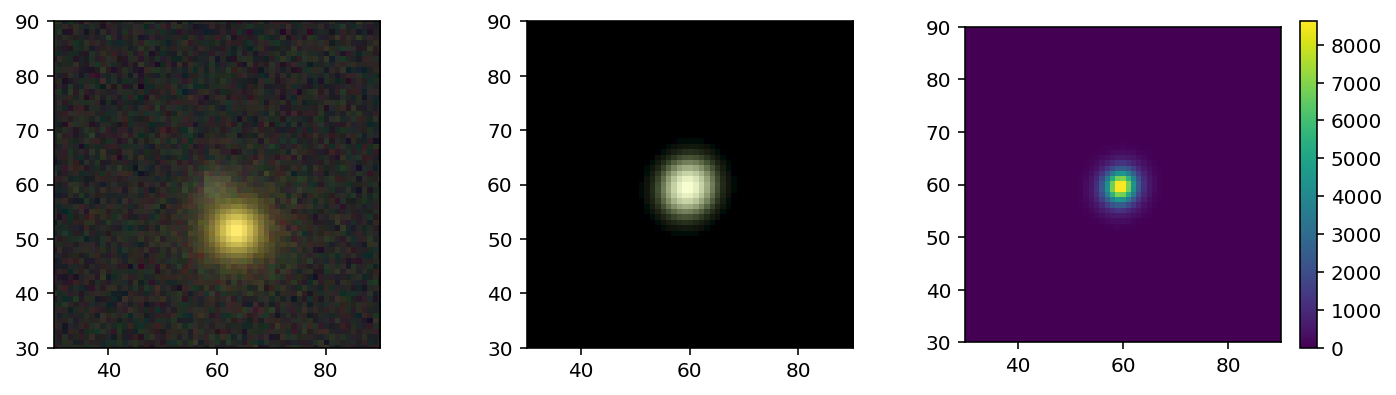

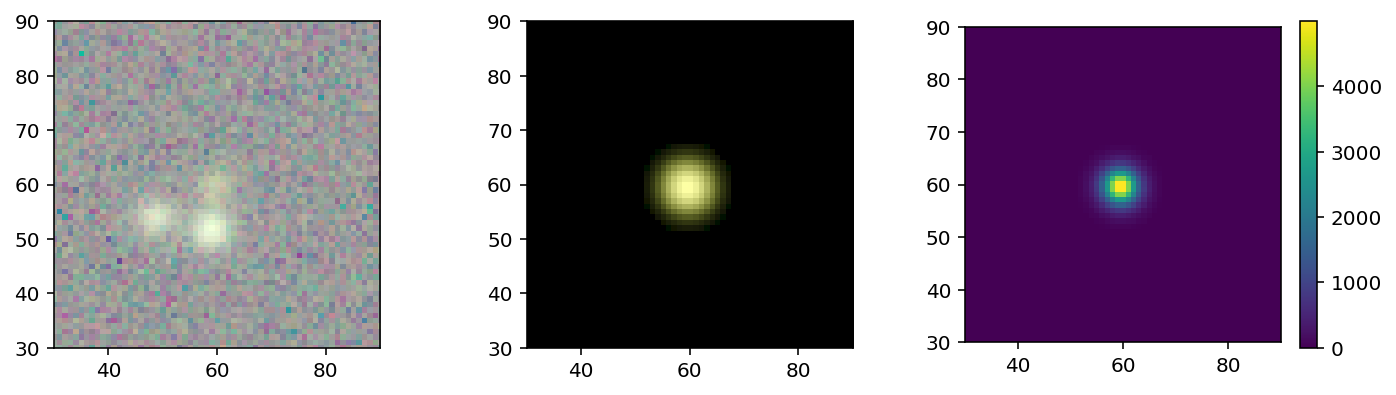

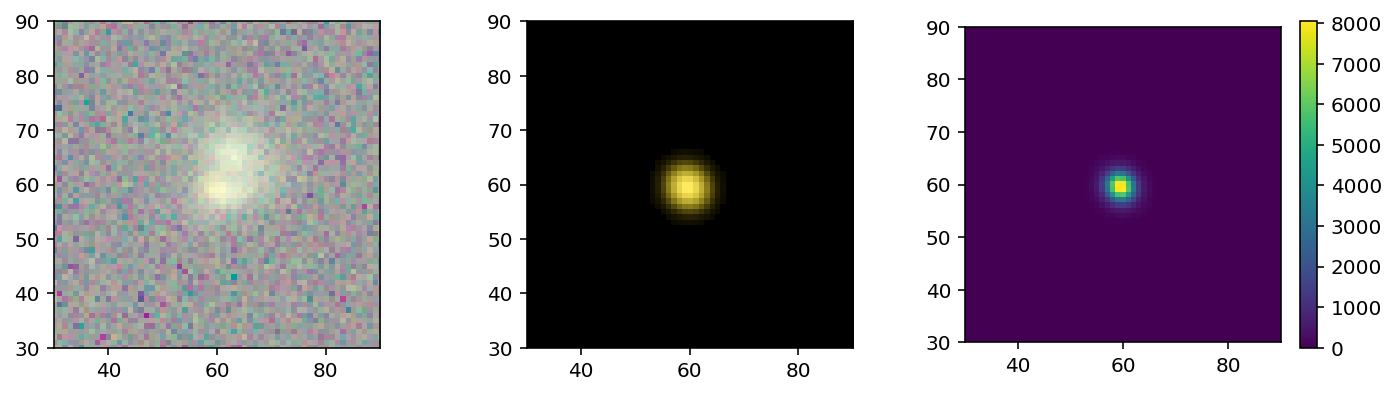

In [153]:
def img_to_rgb(img):
    images = np.transpose(img[:, :, 1:4], axes=(2,0,1))
    norm = scarlet.display.Asinh(img=images, Q=20)
    return scarlet.display.img_to_rgb(images, norm=norm)

for i in range(3):
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].imshow(img_to_rgb(plot_data[0][i]))
    axes[1].imshow(img_to_rgb(plot_data[1][i]))
    ax = axes[2]
    im = ax.imshow(np.sum(plot_data[1][i], axis=2))
    fig.colorbar(im, ax=ax)
    for ax in axes:
        ax.set_xlim(30,90)
        ax.set_ylim(30,90)

(array([1.6000e+01, 1.3700e+02, 1.1420e+03, 5.0110e+03, 1.2095e+04,
        2.6690e+03, 4.8300e+02, 4.5000e+01, 1.0000e+00, 1.0000e+00]),
 array([-2045.84375, -1568.24375, -1090.64375,  -613.04375,  -135.44375,
          342.15625,   819.75625,  1297.35625,  1774.95625,  2252.55625,
         2730.15625]),
 <a list of 10 Patch objects>)

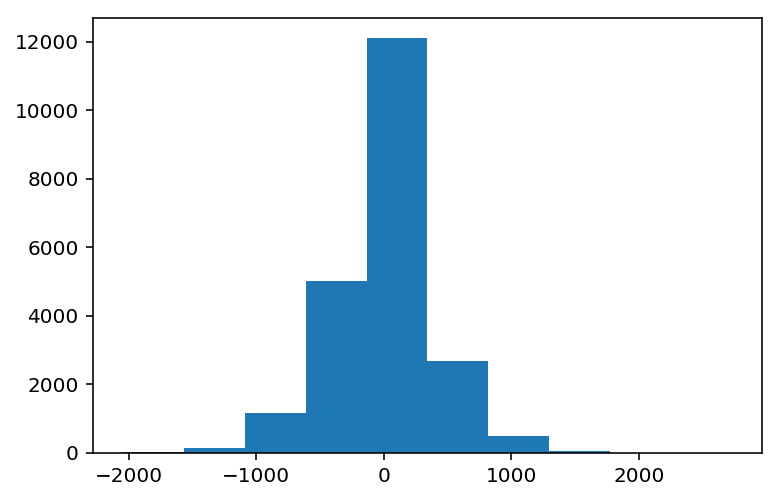

In [156]:
plt.hist(np.ravel(plot_data[0][12,:30,:,:]))

In [136]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class LearningPlot(Callback):
    def __init__(self, plot_data):
        self.plot_data = plot_data
        
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):        
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 4, figsize=(12,3))
        
        ax = axes[0]
        ax.plot(self.loss, c='b')
        ax.plot(self.val_loss, c='r')
        ax.set_xlabel('epoch')
        ax.set_title('Training/validation losses')
        
#         def all_positive(list):
#             return all([x>0. for x in list])
#         if all_positive(self.loss) and all_positive(self.val_loss):
#             ax.set_yscale('log')
        
        idx = np.random.randint(len(self.plot_data[0]))
    
        ax = axes[1]
        ax.imshow(img_to_rgb(self.plot_data[0][idx]))
        ax.set_title('input')
        
        ax = axes[2]
        ax.imshow(img_to_rgb(self.plot_data[1][idx]))
        ax.set_title('target')
        
        ax = axes[3]
        output = model.predict(self.plot_data[0][[idx]])[0]
        ax.imshow(img_to_rgb(output))
        ax.set_title('output')
        
        for i in range(1,4):
            ax.axis('off')
        
        plt.show();
        
learning_plot = LearningPlot(plot_data)

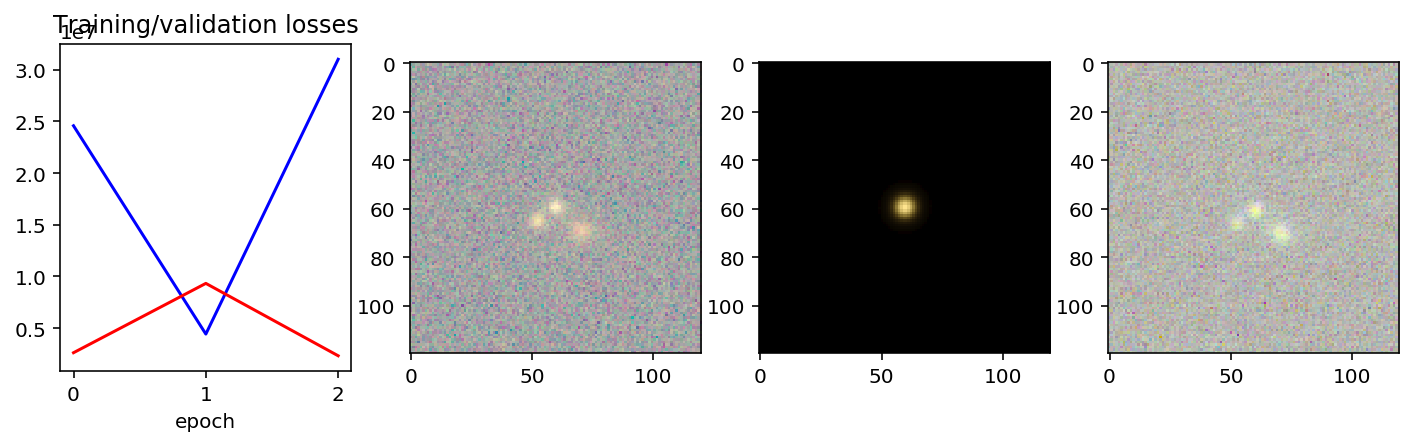

8/8 [==============================] - 87s 11s/step - loss: 31016720.3906 - val_loss: 2330055.5625
Epoch 4/100
4/8 [==============>...............] - ETA: 42s - loss: 4381827.3125

KeyboardInterrupt: 

In [137]:
history = model.fit(dset, epochs=100, steps_per_epoch=8, validation_data=dset_val, validation_steps=2, callbacks=[learning_plot])